# Multi-label классификация по ключевым словам

В данном ноутбуке решается задача классификации статей журнала IEEE по ключевым словам, выделенным из абстракта. 

In [ ]:
import os
import re
from typing import Callable, Union
from string import punctuation
from collections import namedtuple
import copy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
import matplotlib.pyplot as plt
import torch
from torch import nn

## Предобработка

Загрузим собранный датасет в датафрейм `pandas` и начнем предобработку данных.

In [ ]:
ROOT_DIR = os.path.split(os.getcwd())[0]


df = pd.read_csv(
    os.path.join(ROOT_DIR, 'data', 'processed', 'dataset.csv'),
    quotechar='"',
    encoding='utf-8'
)
df.head()

,journal,DOI,abstract,keywords
0,ieee-proc,10.1109/PROC.1984.12812,"The Japanese Super-Speed Computer project, rec...",0000000000000000000000000000000000000000000010...
1,ieee-proc,10.1109/PROC.1984.12813,Supercomputers play important roles in various...,0010000000000000000000000000000000001000000000...
2,ieee-proc,10.1109/PROC.1984.12814,Digital Scene Simulation is Digital Production...,0000000000000000000000000000000000000000100000...
3,ieee-proc,10.1109/PROC.1984.12815,High-speed computers with large memories are v...,0000000000000000000000000000000000000000100000...
4,ieee-proc,10.1109/PROC.1984.12817,This paper presents a case study in the design...,0010000000000000000000000000000000000000001000...


In [ ]:
for _, row in df.iterrows():
    s = row['abstract']
    s = s.lower()                              # make lowercase
    s = re.sub(r'\\[\S]+', '', s)              # remove all backslash sequences
    s = re.sub(r'\[[0-9]+\]', '', s)           # remove citations
    s = re.sub(r'[0-9]+(?:\.[0-9]+)?', '', s)  # remove numbers
    for ch in punctuation:
        s = s.replace(ch, '')
    s = s.encode(encoding='ascii', errors='ignore').decode()
    s = re.sub(r'\s+', ' ', s)       # remove tabs and multiple spaces
    row['abstract'] = s

df.sample()['abstract']

40964    we report a study about the impact of sn compo...
Name: abstract, dtype: object

In [ ]:
Y = np.array([list(map(int, mask)) for mask in df['keywords']])
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

В дальнейшем будем проводить классификацию, предсказывая, сколько слов среди 5  (датасет `top5`) или 100 (датасет `top100`) самых популярных соответствует абстракту. Посмотрим на датасеты:

In [ ]:
n = 5

mask = Y[:, :n].any(axis=1)
print(f'{n} top keywords: {np.sum(mask)} abstracts')
top5 = df[mask].copy()
for _, row in top5.iterrows():
    row['keywords'] = row['keywords'][:n]

top5.sample(5)

5 top keywords: 18929 abstracts


,journal,DOI,abstract,keywords
24883,ieee-tac,10.1109/9.508914,the eigenstructure assignment problem for a li...,10100
7525,ieee-proc,10.1109/PROC.1969.7013,application of broadband panchromatic illumina...,00001
31061,ieee-ted,10.1109/TED.2021.3074115,this article reports the influence of both con...,00010
40060,ieee-ted,10.1109/TED.2020.2989741,the dvdt in superjunction metaloxidesemiconduc...,01000
34105,ieee-ted,10.1109/TED.2018.2866125,with the aid of an analytical and general mode...,01000


In [ ]:
n = 100

mask = Y[:, :n].any(axis=1)
print(f'{n} top keywords: {np.sum(mask)} abstracts')
top100 = df[mask].copy()
for _, row in top100.iterrows():
    row['keywords'] = row['keywords'][:n]

top100.sample(5)

100 top keywords: 53702 abstracts


,journal,DOI,abstract,keywords
21972,ieee-tac,10.1109/TAC.2002.804453,numerical counterexamples and theoretical anal...,0010000000000000000000000000000000000000000000...
29832,ieee-ted,10.1109/TED.2017.2677948,si cmos imagesensor cis cells were designed by...,0001000000000000000000000000000000000000000000...
43236,ieee-tcom,10.1109/TCOMM.2016.2597148,this paper considers optimal multiband transmi...,0000000000000000000000000000000000000000000000...
53,ieee-proc,10.1109/PROC.1972.8633,previous attempts at modeling the early effect...,0010000000000001000000000000000000000000000000...
50424,ieee-tcom,10.1109/TCOMM.2013.093013.120607,link failures in wide area networks are common...,0000000000000000000000100000000000000000000000...


Для того, чтобы получить векторные представления абстрактов, воспользуемся `TF-IDF`.\
Векторное представление для `top5`:

In [ ]:
vectorizer = TfidfVectorizer(max_features=2048, encoding='ascii')
X = vectorizer.fit_transform(top5['abstract'])
y = np.array([list(map(int, mask)) for mask in top5['keywords']],
             dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

X_train.shape

(17036, 2048)

## Метрики

Определим метрики `accuracy`, `precision`, `recall` для нашего случая. Сравниваем one-hot вектора покомпонентно, и каждое такое сравнение компонент считаем за отдельное наблюдение, то есть если в обоих векторах первая компонента равна единице - это вклад в `True Positive`, вторая в предсказанных значениях равна единице, а в реальных нет - это вклад в `False positive`, и так далее.

In [ ]:
Metrics = namedtuple('Metrics', ('accuracy', 'precision', 'recall', 'F2'))


def calculate_metrics(predicted: np.ndarray,
                      answer: np.ndarray) -> Metrics:
    assert predicted.shape == answer.shape
    size = 1
    for x in predicted.shape:
        size *= x

    mask_pred = (predicted == 1)
    mask_ans = (answer == 1)
    true_positives = (mask_pred & mask_ans).sum()
    true_negatives = (~mask_pred & ~mask_ans).sum()
    accuracy = (true_positives + true_negatives) / size

    precision = 0.0
    predicted_positives = mask_pred.sum()
    if predicted_positives > 0:
        precision = true_positives / predicted_positives

    recall = 0.0
    actual_positives = mask_ans.sum()
    if actual_positives > 0:
        recall = true_positives / actual_positives

    F2 = 0.0
    if recall != 0 and precision != 0:
        F2 = 2 * recall * precision / (recall + precision)

    return Metrics(accuracy, precision, recall, F2)

## Классификация без нейронных сетей

К данным было применено 4 различных классификатора: наивный байесовский классификатор, дерево решений, метод опорных векторов и KNN. Сравним их работу на датасете `top5`.

In [ ]:
class MultiLabelClassifier:
    def __init__(self, num_labels: int, binary_classifier: Callable, kwargs: dict):
        self.num_labels = num_labels
        self.classifiers = [binary_classifier(**kwargs)
                            for _ in range(num_labels)]

    def fit(self, X, y):
        for i, clf in enumerate(self.classifiers):
            clf.fit(X, y[:, i])

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.num_labels), dtype='int')
        for i, clf in enumerate(self.classifiers):
            predictions[:, i] = clf.predict(X)
        return predictions

Наивный байесовский классификатор:

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultiLabelClassifier(
    num_labels=5,
    binary_classifier=MultinomialNB,
    kwargs={}
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)


Metrics(accuracy=0.8446909667194928, precision=0.6359163591635917, recall=0.7271448663853727, F2=0.6784776902887139)

Дерево решений:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = MultiLabelClassifier(
    num_labels=5,
    binary_classifier=DecisionTreeClassifier,
    kwargs=dict(max_depth=7, min_samples_leaf=5)
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.8734284204965663, precision=0.7676016027475673, recall=0.6286919831223629, F2=0.6912371134020618)

Метод опорных векторов:

In [ ]:
from sklearn.svm import LinearSVC

clf = MultiLabelClassifier(
    num_labels=5,
    binary_classifier=LinearSVC,
    kwargs={}
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.8842049656629688, precision=0.7780160857908848, recall=0.6802625410220347, F2=0.7258629314657329)

Метод k-ближайших соседей:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.866877971473851, precision=0.7475893363584799, recall=0.6179090482887951, F2=0.6765913757700206)

Значения метрик для этих классификаторов достаточно близки, но лучший результат показал `метод опорных векторов.`

## Классификация с использованием нейронных сетей

Определим класс для работы с датасетом и обучим на датасетах `top5` и `top100` простую нейронную сеть, состоящую из трех полносвязных линейных слоев с функцией активации `ReLU`.

In [ ]:
class AbstractsDataset:
    def __init__(self, X: Union[np.ndarray, sparse.spmatrix],
                 y: Union[np.ndarray, sparse.spmatrix],
                 batch_size: int = 64):
        self.X = copy.deepcopy(X)
        self.y = copy.deepcopy(y)
        self.num_samples, self.num_features = X.shape
        self.batch_size = batch_size
        self.inds = np.arange(self.num_samples)

    def __len__(self):
        return self.num_samples

    def set_batch_size(self, batch_size: int):
        self.batch_size = batch_size

    def shuffle(self):
        self.inds = np.random.permutation(self.num_samples)

    def __iter__(self):
        start = 0
        while start < len(self):
            stop = min(start + self.batch_size, self.num_samples)
            inds = self.inds[start:stop]
            X = self.X[inds]
            if isinstance(X, sparse.spmatrix):
                X = X.toarray()
            y = self.y[inds]
            if isinstance(y, sparse.spmatrix):
                y = y.toarray()
            yield X, y
            start = stop

In [ ]:
class Model(nn.Module):
    """
    Neural net with a single hidden layer.
    """
    def __init__(self, num_features, num_labels, shape_hidden=(1024, 512)):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(num_features, shape_hidden[0]),
            nn.ReLU(),
            nn.Linear(shape_hidden[0], shape_hidden[1]),
            nn.ReLU(),
            nn.Linear(shape_hidden[1], num_labels),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [ ]:
def train(model, train_dataset, val_dataset, device, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = np.zeros(epochs)
    train_metrics = []
    val_losses = np.zeros_like(train_losses)
    val_metrics = []
    loss_function = nn.BCELoss()

    for i in range(epochs):
        print(f'Epoch {i + 1}')

        # train loop
        loss, metrics = single_pass(
            model=model,
            dataset=train_dataset,
            device=device,
            loss_function=loss_function,
            optimizer=optimizer
        )
        train_dataset.shuffle()
        print(f'Train: loss = {loss:.3f},', end=' ')
        print('acc = {:.3f}, prec = {:.3f}, rec = {:.3f}, F2 = {:.3f}'.format(
            metrics.accuracy, metrics.precision,
            metrics.recall, metrics.F2
        ))
        train_losses[i] = loss
        train_metrics.append(metrics)

        # validation loop
        with torch.no_grad():
            loss, metrics = single_pass(
                model=model,
                dataset=val_dataset,
                device=device,
                loss_function=loss_function,
                optimizer=None
            )
        print(f'Validation: loss = {loss:.3f},', end=' ')
        print('acc = {:.3f}, prec = {:.3f}, rec = {:.3f}, F2 = {:.3f}'.format(
            metrics.accuracy, metrics.precision,
            metrics.recall, metrics.F2
        ))
        val_losses[i] = loss
        val_metrics.append(metrics)
        print()

    train_metrics = Metrics(
        accuracy=np.array([m.accuracy for m in train_metrics]),
        precision=np.array([m.precision for m in train_metrics]),
        recall=np.array([m.recall for m in train_metrics]),
        F2=np.array([m.F2 for m in train_metrics]),
    )

    val_metrics = Metrics(
        accuracy=np.array([m.accuracy for m in val_metrics]),
        precision=np.array([m.precision for m in val_metrics]),
        recall=np.array([m.recall for m in val_metrics]),
        F2=np.array([m.F2 for m in val_metrics]),
    )

    return train_losses, val_losses, train_metrics, val_metrics


def single_pass(model, dataset, device, loss_function, optimizer=None):
    # train loop
    losses = []
    accuracies = []
    precision_values = []
    recall_values = []
    F2_values = []
    batch_sizes = []
    for X_j, y_j in dataset:
        # forward loop
        X_j = torch.tensor(X_j, dtype=torch.float32, device=device)
        y_j = torch.tensor(y_j, dtype=torch.float32, device=device)
        output = model.forward(X_j)
        loss = loss_function(output, y_j)
        # evaluate and save metrics
        losses.append(loss.item())
        predicted = np.round(output.cpu().detach().numpy()).astype('uint8')
        m = calculate_metrics(
            predicted, y_j.cpu().numpy().astype('uint8'))
        accuracies.append(m.accuracy)
        precision_values.append(m.precision)
        recall_values.append(m.recall)
        F2_values.append(m.F2)
        batch_sizes.append(X_j.shape[0])

        if optimizer is not None:
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    batch_sizes = np.array(batch_sizes)
    num_samples = np.sum(batch_sizes)
    loss = np.sum(np.array(losses) * batch_sizes) / num_samples
    accuracy = np.sum(np.array(accuracies) * batch_sizes) / num_samples
    precision = np.sum(np.array(precision_values) * batch_sizes) / num_samples
    recall = np.sum(np.array(recall_values * batch_sizes)) / num_samples
    F2 = np.sum(np.array(F2_values * batch_sizes)) / num_samples
    return loss, Metrics(accuracy, precision, recall, F2)

In [ ]:
def plot_results(ax, train_results, val_results, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()
    return ax

Обучим модель на `top5`:

In [ ]:
BATCH_SIZE = 256
HIDDEN_IN = 1024
HIDDEN_OUT = 512
EPOCHS = 50
LEARNING_RATE = 1e-4

train_dataset = AbstractsDataset(X_train, y_train, BATCH_SIZE)
test_dataset = AbstractsDataset(X_test, y_test, BATCH_SIZE)

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(
    num_features=X.shape[1],
    num_labels=y.shape[1],
    shape_hidden=(HIDDEN_IN, HIDDEN_OUT)
)
model = model.to(device)

# train model
train_losses, val_losses, train_metrics, val_metrics = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

Epoch 1
Train: loss = 0.630, acc = 0.747, prec = 0.105, rec = 0.098, F2 = 0.078
Validation: loss = 0.525, acc = 0.775, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 2
Train: loss = 0.482, acc = 0.781, prec = 0.231, rec = 0.041, F2 = 0.067
Validation: loss = 0.425, acc = 0.816, prec = 0.781, rec = 0.258, F2 = 0.387

Epoch 3
Train: loss = 0.381, acc = 0.831, prec = 0.717, rec = 0.423, F2 = 0.529
Validation: loss = 0.360, acc = 0.837, prec = 0.706, rec = 0.473, F2 = 0.566

Epoch 4
Train: loss = 0.345, acc = 0.838, prec = 0.712, rec = 0.476, F2 = 0.570
Validation: loss = 0.338, acc = 0.842, prec = 0.732, rec = 0.473, F2 = 0.574

Epoch 5
Train: loss = 0.322, acc = 0.847, prec = 0.755, rec = 0.477, F2 = 0.584
Validation: loss = 0.318, acc = 0.853, prec = 0.776, rec = 0.490, F2 = 0.600

Epoch 6
Train: loss = 0.302, acc = 0.861, prec = 0.788, rec = 0.528, F2 = 0.632
Validation: loss = 0.304, acc = 0.865, prec = 0.800, rec = 0.536, F2 = 0.641

Epoch 7
Train: loss = 0.286, acc = 0.873, prec = 0.8

Посмотрим на изменение метрик с ростом количества эпох для `top5`.

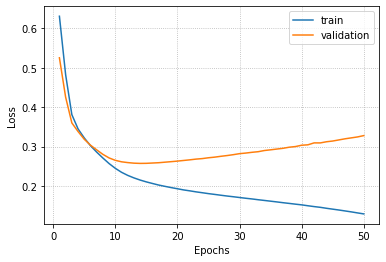

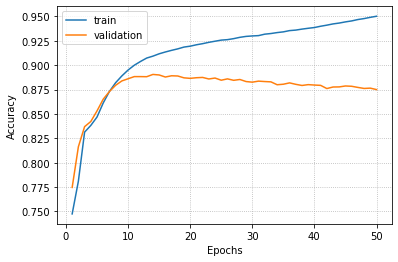

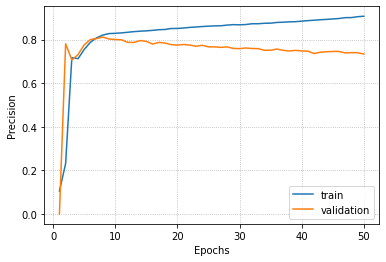

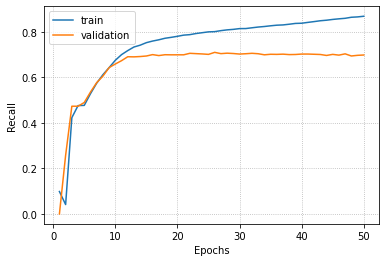

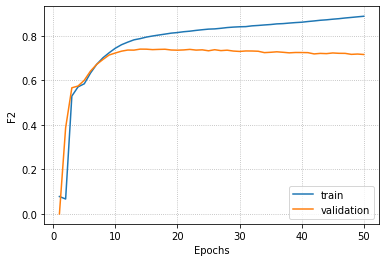

In [ ]:
plt.close('all')
_, ax1 = plt.subplots()
ax1 = plot_results(ax1, train_losses, val_losses, 'Loss')
_, ax2 = plt.subplots()
ax2 = plot_results(ax2, train_metrics.accuracy, val_metrics.accuracy, 'Accuracy')
_, ax3 = plt.subplots()
ax3 = plot_results(ax3, train_metrics.precision, val_metrics.precision, 'Precision')
_, ax4 = plt.subplots()
ax4 = plot_results(ax4, train_metrics.recall, val_metrics.recall, 'Recall')
_, ax5 = plt.subplots()
ax5 = plot_results(ax5, train_metrics.F2, val_metrics.F2, 'F2')
plt.show()

Метрики достаточно быстро растут при обучении. Видно, что к 50 эпохе классификатор, основанный на нейронных сетях, работает намного лучше, чем другие классификаторы.

Сделаем все то же самое для `top100`.

In [ ]:
vectorizer = TfidfVectorizer(max_features=2048, encoding='ascii')
X = vectorizer.fit_transform(top100['abstract'])
y = np.array([list(map(int, mask)) for mask in top100['keywords']],
             dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

X_train.shape

(48331, 2048)

Посмотрим, как работает метод опорных векторов:

In [ ]:
clf = MultiLabelClassifier(
    num_labels=100,
    binary_classifier=LinearSVC,
    kwargs={}
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.9744312046173896, precision=0.6763680724991287, recall=0.24630323031033827, F2=0.36110723424052105)

А теперь обучим нейронную сеть:

In [ ]:
BATCH_SIZE = 2048
HIDDEN_IN = 1024
HIDDEN_OUT = 512
EPOCHS = 100
LEARNING_RATE = 5e-4

train_dataset = AbstractsDataset(X_train, y_train, BATCH_SIZE)
test_dataset = AbstractsDataset(X_test, y_test, BATCH_SIZE)

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(
    num_features=X.shape[1],
    num_labels=y.shape[1],
    shape_hidden=(HIDDEN_IN, HIDDEN_OUT)
)
model = model.to(device)

# train model
train_losses, val_losses, train_metrics, val_metrics = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

Epoch 1
Train: loss = 0.511, acc = 0.891, prec = 0.010, rec = 0.085, F2 = 0.016
Validation: loss = 0.146, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 2
Train: loss = 0.151, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000
Validation: loss = 0.135, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 3
Train: loss = 0.134, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000
Validation: loss = 0.132, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 4
Train: loss = 0.132, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000
Validation: loss = 0.131, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 5
Train: loss = 0.131, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000
Validation: loss = 0.130, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 6
Train: loss = 0.130, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000
Validation: loss = 0.130, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 7
Train: loss = 0.129, acc = 0.971, prec = 0.0

Train: loss = 0.073, acc = 0.976, prec = 0.756, rec = 0.264, F2 = 0.392
Validation: loss = 0.084, acc = 0.974, prec = 0.665, rec = 0.226, F2 = 0.338

Epoch 54
Train: loss = 0.072, acc = 0.976, prec = 0.757, rec = 0.269, F2 = 0.397
Validation: loss = 0.084, acc = 0.974, prec = 0.667, rec = 0.229, F2 = 0.341

Epoch 55
Train: loss = 0.072, acc = 0.976, prec = 0.760, rec = 0.273, F2 = 0.401
Validation: loss = 0.084, acc = 0.974, prec = 0.660, rec = 0.237, F2 = 0.349

Epoch 56
Train: loss = 0.071, acc = 0.976, prec = 0.761, rec = 0.278, F2 = 0.408
Validation: loss = 0.084, acc = 0.974, prec = 0.664, rec = 0.233, F2 = 0.345

Epoch 57
Train: loss = 0.071, acc = 0.976, prec = 0.762, rec = 0.282, F2 = 0.412
Validation: loss = 0.084, acc = 0.974, prec = 0.661, rec = 0.238, F2 = 0.350

Epoch 58
Train: loss = 0.070, acc = 0.976, prec = 0.766, rec = 0.287, F2 = 0.417
Validation: loss = 0.084, acc = 0.974, prec = 0.660, rec = 0.240, F2 = 0.352

Epoch 59
Train: loss = 0.070, acc = 0.976, prec = 0.767

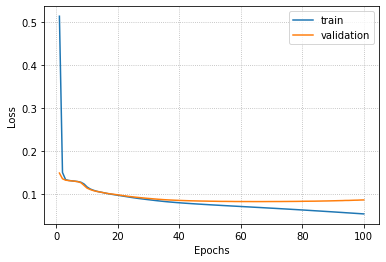

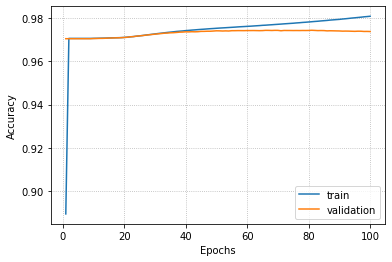

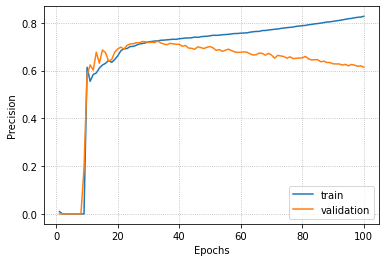

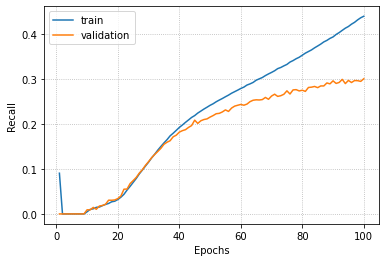

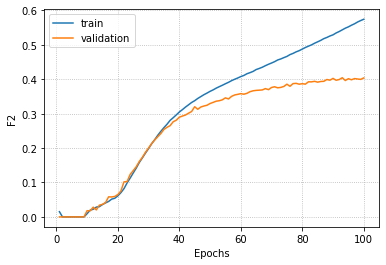

In [ ]:
plt.close('all')
_, ax1 = plt.subplots()
ax1 = plot_results(ax1, train_losses, val_losses, 'Loss')
_, ax2 = plt.subplots()
ax2 = plot_results(ax2, train_metrics.accuracy, val_metrics.accuracy, 'Accuracy')
_, ax3 = plt.subplots()
ax3 = plot_results(ax3, train_metrics.precision, val_metrics.precision, 'Precision')
_, ax4 = plt.subplots()
ax4 = plot_results(ax4, train_metrics.recall, val_metrics.recall, 'Recall')
_, ax5 = plt.subplots()
ax5 = plot_results(ax5, train_metrics.F2, val_metrics.F2, 'F2')
plt.show()

Здесь метрики тоже быстро растут, но recall и F2 score достигают значительно меньших значений, чем в `top5`, что означает, что модель чаще выдает в качестве ключевых слов те, которых не было в собранных данных. Но поскольку precision достаточно высокий, можно говорить о том, что те ключевые слова, которые там были, модель тоже предсказывает неплохо.